# Solve the wave equation

In [1]:
function coords(nn, ni, dt, dx)
    t = [n * dt for i in 0:ni, n in 0:nn]
    x = [i * dx for i in 0:ni, n in 0:nn]
    return t, x
end

coords (generic function with 1 method)

In [2]:

nn = 100
ni = 100
dt = (1)/(nn)
dx = 1/(ni)
t, x = coords(nn, ni, dt, dx);

In [3]:
using Random
using CairoMakie

In [4]:
function standing(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    for n in 1:2, i in 1:ni
        u[i, n] = cos(2π * t[i, n]) * sin(2π * x[i, n])
#         u[i, n] = exp(2π * t[i, n] * x[i, n])
#         u[i, n] = real(exp(im * 2π * t[i, n] * x[i, n]))
#         u[i, n] = imag(exp(im * 2π * t[i, n] * x[i, n]))
#         p = exp(im * 2π * t[i, n] * x[i, n])
#         u[i, n] = p * conj(p)
#         u[i, n] = real(exp(im * 2π * t[i, n] * x[i, n]))-imag(exp(im * 2π * t[i, n] * x[i, n]))
    end
    return u
end

function delta(t,x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    set = rand(MersenneTwister(0), 1:ni-1, 15)
    # Initial conditions for first two points in time
    for n in 1:2, i in set
        
        u[i, n] = 5*cos(π/5 * i) #cos(2π * t[n, i]) * sin(2π * x[n, i])
    end
    
    return u
end

delta (generic function with 1 method)

In [5]:
# u = standing(t, x);
u = delta(t,x);

In [86]:
# ] add CairoMakie

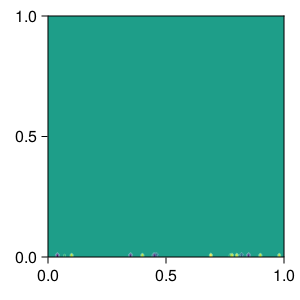

In [6]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
fig

In [7]:
#find the solution at one interior point
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
#     finite difference for second derivative in x direction
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1])/dx^2
#     time derivative
#     utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n])/dt^2
#     solve for u[i,n]
#     utt = uxx
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

evolve_point! (generic function with 1 method)

In [8]:
# find the solution for one point in time
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    #dirischelet boundary conditon - set to 0
    u[1,n] = 0
    u[ni,n] = 0
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    
    return
end


evolve_step! (generic function with 1 method)

In [9]:
# find the solution everywhere
function evolve!(u, dt, dx)
    ni, nn = size(u)
#     loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

In [19]:
# find the solution everywhere
function swapBoundary!(u, dt, dx)
    ni, nn = size(u)
#     loop over all times
    for n in 1:3
        for i in 1:ni
#             print(n)
            u[i,n] = u[i,nn-3 + n]
        end
    end
    return
end

swapBoundary! (generic function with 1 method)

In [20]:
# find the solution everywhere
function swapBoundaryRev!(u, dt, dx)
    ni, nn = size(u)
#     loop over all times
    for n in 1:3
        for i in 1:ni
#             print(n)
            u[i,n] = u[i,nn-(n-1)]
        end
    end
    return
end

swapBoundaryRev! (generic function with 1 method)

In [21]:
# find the solution everywhere
function reverseAll!(u, dt, dx)
    ni, nn = size(u)
    nu = zeros(ni,nn)
#     loop over all times
    for n in 1:nn
        for i in 1:ni
#             print(n)
            nu[i,n] = u[i,nn-(n-1)]
        end
    end
    return nu
end

reverseAll! (generic function with 1 method)

In [22]:
s = [0,102,2,3,4]
for n in 1:3
#     for i in 0:
    print(n)         
    s[n] = s[5-4 + n]
#     end
end

123

In [23]:
print(s)

[102, 2, 3, 3, 4]

In [24]:
# swapBoundary!(u, dt, dx)
evolve!(u,dt,dx)

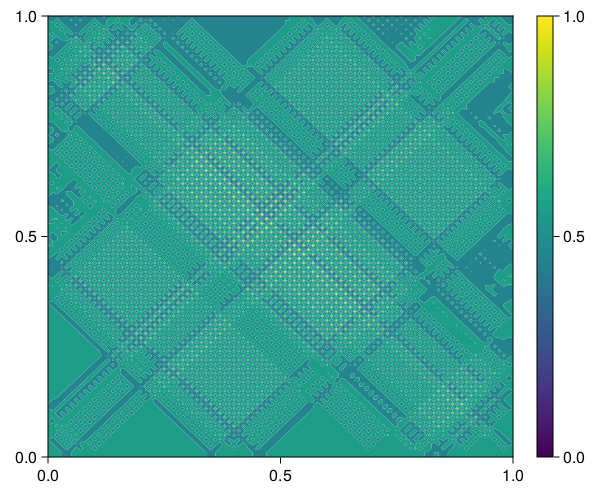

In [25]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1,2],colormap=:viridis)
fig

In [26]:

# swapBoundaryRev!(u, dt, dx)
nu = reverseAll!(u, dt, dx)
evolve!(nu,dt,dx)

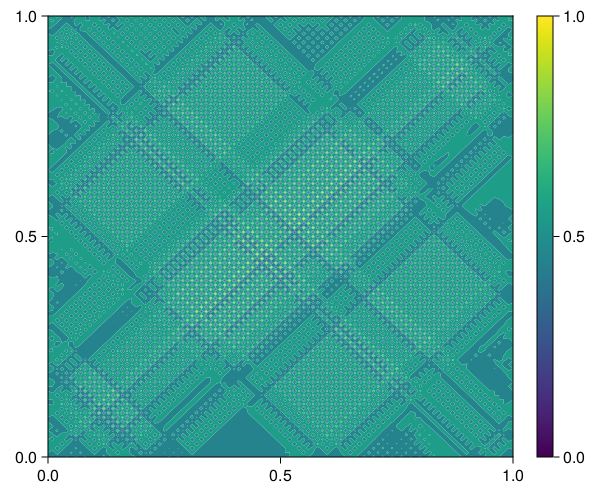

In [27]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(nu))
Colorbar(fig[1,2],colormap=:viridis)
fig

In [99]:
swapBoundaryRev!(u, dt, dx)
evolve!(u,dt,dx)

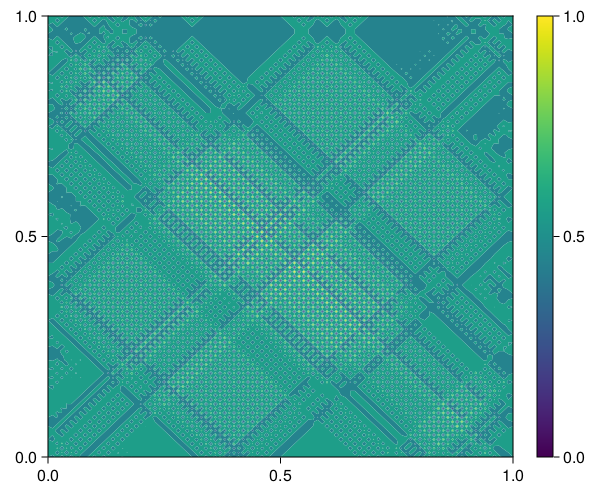

In [100]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1,2],colormap=:viridis)
fig

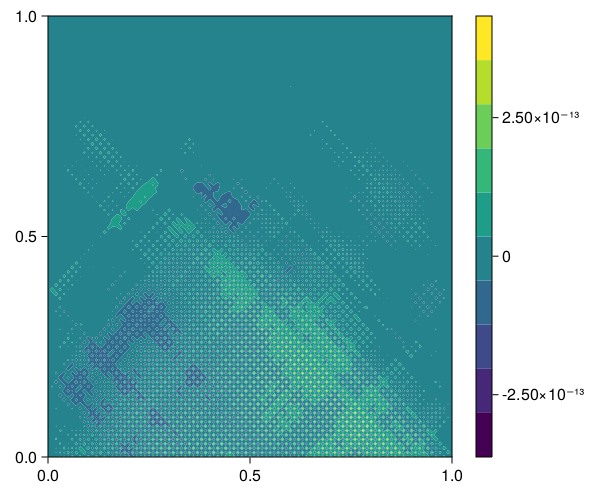

In [28]:
nu = reverseAll!(nu, dt, dx)
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(u .- nu))
Colorbar(fig[1,2],co)
fig

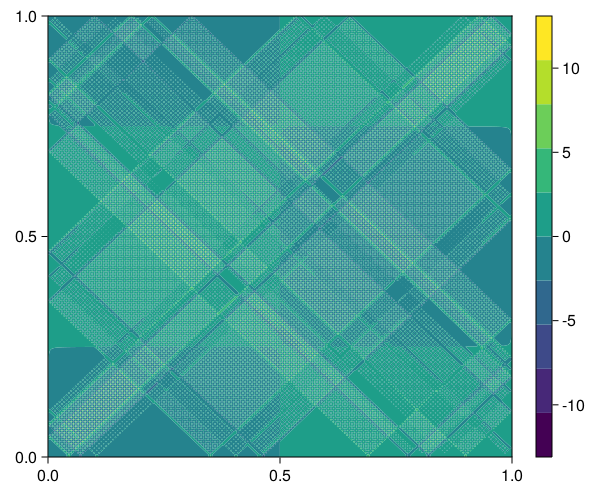

In [33]:

fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(u .- cos.(2π * t) .* sin.(2π * x)))
Colorbar(fig[1,2],co)
fig